# Computing spectroscopic completeness 

Jaime E. Forero-Romero, April 2022.

Nearing one year after the main DESI survey started, there are regions in the footprint that
have already been observed at full depth. In this notebook we can see how to compute the spectroscopic completenes on one of such regions covering 135 squared degrees, i.e., 1% of the full survey, approximately.

We start by defining first the sky region to compute the completeness and then finding what tiles that have been observed on that region. With that information we read the corresponding input targets, fiberassign outputs, redrock outputs and zmtl files. With those files at hand, we can finally compute the spectroscopic completeness

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
import os
from desitarget.targetmask import desi_mask, bgs_mask, mws_mask
from desitarget.targetmask import obsmask, obsconditions, zwarn_mask
from astropy.table import Table
plt.style.use('desi.mplstyle')

Depending on the survey program that we want to inspect (either `maindark` or `mainbright`)
we define the boudaries of the regions where the completeness will be computed.
Those regions have been observed at full depth.
Why those boundaries in particular? See the thread started by David Schlegel on [desi-survey 3694]

Check by yourself what happens if we change `faflavor=maindark` to `faflavor=mainbright`

In [31]:
faflavor = 'maindark'

if faflavor == 'maindark':
    min_ra = 129.0
    min_dec = -6.0
    max_ra = 149.0
    max_dec = 1
    buffer = 2.0
elif faflavor == 'mainbright':
    min_ra = 129.0
    min_dec = -6.0
    max_ra = 146.0
    max_dec = 2
    buffer = 2.0

area = (np.deg2rad(max_ra) - np.deg2rad(min_ra)) * (np.cos(np.deg2rad(90-max_dec)) - np.cos(np.deg2rad(90-min_dec)))
area = area*((180/np.pi)**2)
print('This patch has an area of {:.2f} sqdeg'.format(area))

This patch has an area of 139.78 sqdeg


We now read the uptodate list of all tiles that have been observed so far.
After doing that, we are going to keep only the tiles that have their centers within
the region we have already defined. We add a buffer of two degrees around that region.

In [35]:
observed_tiles = Table.read("/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/ops/tiles-specstatus.ecsv")

ii = (observed_tiles['FAFLAVOR'] == faflavor) & (observed_tiles['ZDONE']=='true')
ii &= observed_tiles['TILERA']>(min_ra-buffer)
ii &= observed_tiles['TILERA']<(max_ra+buffer)
ii &= observed_tiles['TILEDEC']>(min_dec-buffer)
ii &= observed_tiles['TILEDEC']<(max_dec+buffer)

observed_tiles = observed_tiles[ii]

In [36]:
observed_tiles

TILEID,SURVEY,FAPRGRM,FAFLAVOR,NEXP,EXPTIME,TILERA,TILEDEC,EFFTIME_ETC,EFFTIME_SPEC,EFFTIME_GFA,GOALTIME,OBSSTATUS,ZDONE,LRG_EFFTIME_DARK,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GOALTYPE,MINTFRAC,LASTNIGHT,QA,USER,OVERRIDE,QANIGHT,ARCHIVEDATE
int64,str7,str16,str19,int64,float64,float64,float64,float64,float64,float64,float64,str8,str5,float64,float64,float64,float64,str7,float64,int64,str6,str19,int64,int64,int64
2514,main,dark,maindark,2,2667.9,145.802,1.84,1002.8,1046.9,842.9,1000.0,obsend,true,1046.9,1086.9,1009.5,720.1,dark,0.85,20220326,good,rongpu,0,20220326,20220328
2517,main,dark,maindark,1,1411.2,142.496,2.309,1006.4,985.0,848.1,1000.0,obsend,true,985.0,1078.9,914.6,764.7,dark,0.85,20220226,good,AJR,0,20220226,20220228
2519,main,dark,maindark,1,855.0,143.749,-0.791,1004.6,890.6,967.3,1000.0,obsend,true,890.6,948.9,851.0,1208.1,dark,0.85,20211211,good,adamyers,0,20211211,20211214
2520,main,dark,maindark,2,1888.3,147.055,-1.253,1007.7,934.3,999.2,1000.0,obsend,true,934.3,975.3,919.1,888.2,dark,0.85,20220131,good,rongpu,0,20220131,20220201
2521,main,dark,maindark,2,1891.4,149.126,1.365,1002.5,933.1,992.0,1000.0,obsend,true,933.1,967.5,923.2,990.0,dark,0.85,20220325,good,rongpu,0,20220325,20220328
2526,main,dark,maindark,3,3854.0,140.444,-0.324,1008.1,1004.8,0.0,1000.0,obsend,true,1004.8,1034.5,1029.0,1669.7,dark,0.85,20211212,good,sgontcho,0,20211212,20211214
2527,main,dark,maindark,1,1449.2,137.138,0.133,1005.7,1029.8,969.2,1000.0,obsend,true,1029.8,1058.4,999.2,1112.2,dark,0.85,20220130,good,rongpu,0,20220130,20220201
2529,main,dark,maindark,1,855.6,133.737,0.65,1005.4,939.0,909.6,1000.0,obsend,true,939.0,993.0,887.1,1221.1,dark,0.85,20220103,good,AJR,0,20220103,20220112
2530,main,dark,maindark,1,1042.1,135.008,-2.436,1004.4,927.6,950.9,1000.0,obsend,true,927.6,938.9,917.1,1286.8,dark,0.85,20211130,good,rongpu,0,20211130,20211201


(-6.0, 1.0)

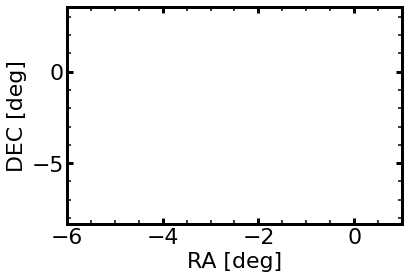

In [45]:
plt.scatter(observed_tiles['TILERA'], observed_tiles['TILEDEC'], s=2000, alpha=0.2)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.xlim(min_ra, max_ra)
plt.xlim(min_dec, max_dec)

# 3 . Read all the targets, fba, fba_exp, redrock, and zmtl outputs for those tiles



In [10]:
z = []
fba = []
exp_fba = []
target = []
zmtl = []

main_path = "/global/cfs/cdirs/desi/spectro/redux/daily/tiles/archive/"
for i in range(len(observed_tiles)):
    tileid = observed_tiles['TILEID'][i]
    lastnight = observed_tiles['LASTNIGHT'][i]
    archive = observed_tiles['ARCHIVEDATE'][i]
    rr_path = os.path.join(main_path, 
                        "{}".format(tileid), "{}".format(archive))
    target_path = os.path.join("/global/cfs/cdirs/desi/survey/fiberassign/main/",
                              "{:03d}".format(tileid//1000))
    # gather all targets
    try:
        target_file = os.path.join(target_path, "{:06d}-targ.fits".format(tileid))
        target.append(fitsio.read(target_file))
    except:
        print('failed for targets', tileid)
    
    # gather all redrock outputs
    for petal in range(10):
        redrock_file = os.path.join(rr_path, "redrock-{}-{}-thru{}.fits".format(petal, tileid, lastnight))
        try:
            z.append(fitsio.read(redrock_file, ext="REDSHIFTS"))
            fba.append(fitsio.read(redrock_file, ext="FIBERMAP"))
            exp_fba.append(fitsio.read(redrock_file, ext="EXP_FIBERMAP"))
        except:
            print(redrock_file)
            print("failed for", petal, tileid, lastnight)
            
    # gather all zmtl outputs
    for petal in range(10):
        zmtl_file = os.path.join(rr_path, "zmtl-{}-{}-thru{}.fits".format(petal, tileid, lastnight))
        try:
            petal_zmtl = fitsio.read(zmtl_file, ext="ZMTL")
            bad = petal_zmtl["ZWARN"] & zwarn_mask.mask("NODATA|BAD_SPECQA|BAD_PETALQA") != 0
            #bad = petal_zmtl["ZWARN"]!=0
            petal_zmtl = petal_zmtl[~bad]
            zmtl.append(petal_zmtl)
        except:
            print("zmtl failed for", petal, tileid, lastnight)        
        
data_z = np.hstack(z)
data_fba = np.hstack(fba)
data_exp_fba = np.hstack(exp_fba)
data_target = np.hstack(target)
data_zmtl = np.hstack(zmtl)

/global/cfs/cdirs/desi/spectro/redux/daily/tiles/archive/8776/20220112/redrock-7-8776-thru20220104.fits
failed for 7 8776 20220104
zmtl failed for 7 8776 20220104
/global/cfs/cdirs/desi/spectro/redux/daily/tiles/archive/8777/20220112/redrock-7-8777-thru20220104.fits
failed for 7 8777 20220104
zmtl failed for 7 8777 20220104


In [11]:
len(data_zmtl)

697413

In [12]:
# unique target ids

_, unique_ii = np.unique(data_target['TARGETID'], return_index=True)
data_target = data_target[unique_ii]

#_, unique_ii = np.unique(data_fba['TARGETID'], return_index=True)
#data_fba = data_fba[unique_ii]

#_, unique_ii = np.unique(data_z['TARGETID'], return_index=True)
#data_z = data_z[unique_ii]

#_, unique_ii = np.unique(data_exp_fba['TARGETID'], return_index=True)
#data_exp_fba = data_exp_fba[unique_ii]


In [13]:
ii = data_target['RA']>(min_ra)
ii &= data_target['RA']<(max_ra)
ii &= data_target['DEC']>(min_dec)
ii &= data_target['DEC']<(max_dec)

data_target = data_target[ii]

#ii = data_fba['TARGET_RA']>(min_ra)
#ii &= data_fba['TARGET_RA']<(max_ra)
#ii &= data_fba['TARGET_DEC']>(min_dec)
#ii &= data_fba['TARGET_DEC']<(max_dec)

ii = np.isin(data_fba['TARGETID'], data_target['TARGETID'])
data_fba = data_fba[ii]

ii = np.isin(data_exp_fba['TARGETID'], data_target['TARGETID'])
data_exp_fba = data_exp_fba[ii]

ii = np.isin(data_z['TARGETID'], data_target['TARGETID'])
data_z = data_z[ii]

ii = np.isin(data_zmtl['TARGETID'], data_target['TARGETID'])
data_zmtl = data_zmtl[ii]

In [14]:
data_fba['TARGET_RA']

array([145.45211532, 145.57227804, 145.66087571, ..., 134.62986378,
       134.64804533, 134.75205671])

In [15]:
len(set(data_zmtl['TARGETID']))-len(data_zmtl['TARGETID'])

-50905

455697


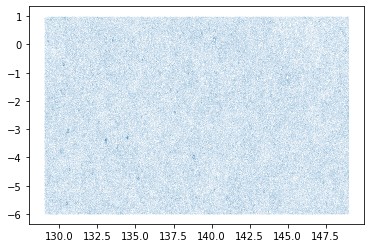

In [16]:
plt.scatter(data_target['RA'], data_target['DEC'], s=0.01, alpha=0.1)
print(len(data_target['RA']))

380789


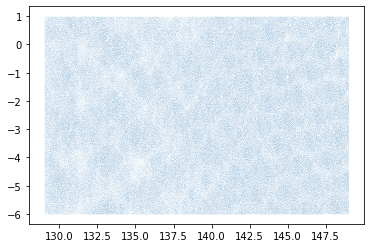

In [90]:
plt.scatter(data_fba['TARGET_RA'], data_fba['TARGET_DEC'], s=0.01, alpha=0.1)
print(len(data_fba['TARGET_RA']))

523816


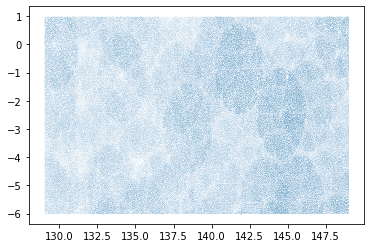

In [91]:
plt.scatter(data_exp_fba['FIBER_RA'], data_exp_fba['FIBER_DEC'], s=0.01, alpha=0.1)
print(len(data_exp_fba['FIBER_RA']))

323754


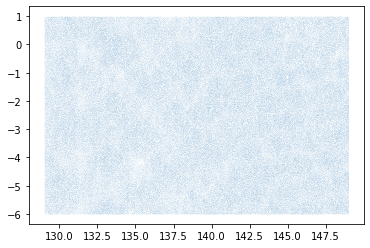

In [92]:
ii_z = np.isin(data_target['TARGETID'], data_z['TARGETID'])
plt.scatter(data_target['RA'][ii_z], data_target['DEC'][ii_z], s=0.01, alpha=0.1)
print(len(data_target['RA'][ii_z]))

280312


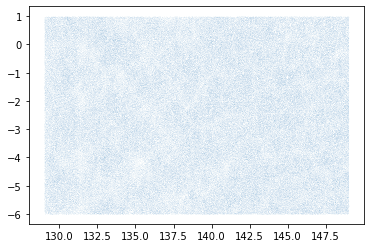

In [93]:
ii_z = np.isin(data_target['TARGETID'], data_zmtl['TARGETID'])
plt.scatter(data_target['RA'][ii_z], data_target['DEC'][ii_z], s=0.01, alpha=0.1)
print(len(data_target['RA'][ii_z]))

In [94]:
area = (np.deg2rad(max_ra) - np.deg2rad(min_ra)) * (np.cos(np.deg2rad(90-max_dec)) - np.cos(np.deg2rad(90-min_dec)))
area = area*((180/np.pi)**2)
print(area)

139.77978030856207


In [95]:
if faflavor == 'mainbright':
    targets = {'BGS_BRIGHT':'BGS_BRIGHT', 'BGS_FAINT':'BGS_FAINT', 
               'BGS_FAINT_HIP':'BGS_FAINT_HIP', 'BGS_WISE':'BGS_WISE', 'MWS_ANY':'MWS_ANY'}
    mask = bgs_mask
    target_mask = 'BGS_TARGET'
    format_data = '{} \t{:.0f}\t {:.0f}\t {:.0f}\t {:.0f}\t\t{:.3f}\t {:.3f}'
    
elif faflavor == 'maindark':

    targets = {'LRG':'LRG', 'ELG':'ELG', 'QSO':'QSO', #'QSO_LYA':'QSO', 
           'ELG_HIP':'ELG_HIP', 'ELG_LOP':'ELG_LOP', 'ELG_VLO': 'ELG_VLO', 'MWS_ANY':'MWS_ANY'}
    z_min = {'LRG':0.4, 'ELG':0.6, 'QSO_TRACER':0.0, 'QSO_LYA':2.1, 
        'ELG_LOP':0.6, 'ELG_HIP':0.6, 'ELG_VLO':0.6}

    z_max = {'LRG':1.1, 'ELG':1.6, 'QSO_TRACER':2.1, 'QSO_LYA':10.0,
        'ELG_LOP':1.6, 'ELG_HIP':1.6, 'ELG_VLO':1.6}
    mask = desi_mask
    target_mask = 'DESI_TARGET'
    format_data = '{}\t\t{:.0f}\t {:.0f}\t {:.0f}\t {:.0f}\t\t{:.3f}\t {:.3f}'

format_header = '{}\t\t{}\t {}\t {}\t {}\t{}\t {}'.format('TARGET', 'NOBJ', 'NOBS', 'NGOODZ', 'DENS(OBJ)', 'FOBS', 'FGOODZ')
print(format_header)
for t in targets.keys():
    if t=='MWS_ANY' and faflavor=='mainbright':
        mask = desi_mask
        target_mask = 'DESI_TARGET'
    is_target = (data_target[target_mask] & mask[targets[t]])!=0
    
    #in fiberassign
    is_fba = np.isin(data_exp_fba['TARGETID'], data_target['TARGETID'][is_target])
    
    #with a good redshift
    is_z = np.isin(data_zmtl['TARGETID'], data_target['TARGETID'][is_target])
    
    n_in_fba = len(np.unique(data_exp_fba['TARGETID'][is_fba]))
    n_with_z = len(np.unique(data_zmtl['TARGETID'][is_z]))
    n_target = np.count_nonzero(is_target) 
    
    print(format_data.format(t, n_target, n_in_fba, n_with_z, n_target/area,
                                                        n_in_fba/n_target, n_with_z/n_target))

TARGET		NOBJ	 NOBS	 NGOODZ	 DENS(OBJ)	FOBS	 FGOODZ
LRG		87417	 79052	 78042	 625		0.904	 0.893
ELG		327268	 213461	 174767	 2341		0.652	 0.534
QSO		39410	 39252	 34745	 282		0.996	 0.882
ELG_HIP		32726	 30406	 25187	 234		0.929	 0.770
ELG_LOP		262078	 185346	 147833	 1875		0.707	 0.564
ELG_VLO		65190	 28115	 26934	 466		0.431	 0.413
MWS_ANY		16631	 7207	 7096	 119		0.433	 0.427
